# OASIS Brain Stylegan

## Import Packages

In [842]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# tf_device='/gpu:0'import time
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))


import matplotlib.pyplot as plt
import pandas as pd
from random import random, randint
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from IPython.display import clear_output
import time
from tqdm import tqdm
import numpy as np
import tensorflow_datasets as tfds
import glob
import imageio

print("Import Complete")

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Import Complete


## Set up constant variables

In [824]:
BATCH_SIZE = 256
EPOCHS = 50
IMAGE_SIZE = 28
h, w = IMAGE_SIZE, IMAGE_SIZE

## Load Data

In [825]:
train_ds, ds_info = tfds.load(
    'mnist',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
train_ds = train_ds['train']
train_ds = train_ds.map(lambda x, y: layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(x))
train_ds = train_ds.shuffle(BATCH_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

## Preview Data

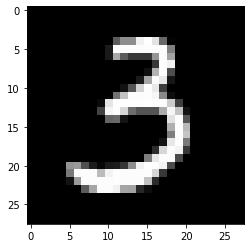

Shape: (28, 28, 1)
Data Type: <dtype: 'float32'>
Min tf.Tensor(-1.0, shape=(), dtype=float32)
Max tf.Tensor(1.0, shape=(), dtype=float32)


In [826]:
imageNum = randint(0, BATCH_SIZE-1)
previewImage = list(train_ds.take(1))[0][imageNum]
plt.imshow(previewImage, cmap='gray')
plt.show()

print("Shape:", previewImage.shape)
print("Data Type:", previewImage.dtype)
print("Min", tf.math.reduce_min(previewImage))
print("Max", tf.math.reduce_max(previewImage))

## Initialize Models

In [827]:
LATENT_SIZE = 100

def make_generator_model():
    # AdaIN
    def AdaIN(x, ys, yb):
        x_mean, x_std = k.mean(x), k.std(x)
        ys = tf.reshape(ys, (-1, 1, 1, tf.shape(ys)[-1]))
        yb = tf.reshape(yb, (-1, 1, 1, tf.shape(yb)[-1]))
        return tf.add(tf.multiply(ys, tf.divide(x - x_mean, x_std+1e-7)), yb)

    input_layer0 = layers.Input((LATENT_SIZE,))
    input_layer1 = layers.Input((LATENT_SIZE,))
    input_layer2 = layers.Input((LATENT_SIZE,))

    # Mapping Network
    mnfc_input = layers.Input(shape=(LATENT_SIZE,))
    mnfc = layers.Dense(LATENT_SIZE, activation="relu")(mnfc_input)
    for i in range(7):
        mnfc = layers.Dense(LATENT_SIZE, activation="relu")(mnfc)
    mapping_network = tf.keras.Model(inputs=[mnfc_input], outputs=[mnfc])

    w0 = mapping_network(input_layer0)
    w1 = mapping_network(input_layer1)
    w2 = mapping_network(input_layer2)

    # Noises
    noise_input0 = layers.Input(shape=(7, 7, 1))
    n0 = layers.Dense(32, activation="relu")(noise_input0)
    noise_input1 = layers.Input(shape=(14, 14, 1))
    n1 = layers.Dense(32, activation="relu")(noise_input1)
    noise_input2 = layers.Input(shape=(28, 28, 1))
    n2 = layers.Dense(32, activation="relu")(noise_input2)

    # Synthesis Network
    # 7x7
    x = layers.Dense(7*7*32)(input_layer2)
    x = layers.Reshape((7, 7, 32))(x)
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    b = layers.Dense(32)(n0)
    x = layers.Add()([x, b])
    scale_dense = layers.Dense(32)(w0)
    bias_dense = layers.Dense(32)(w0)
    x = AdaIN(x, scale_dense, bias_dense)

    # 14x14
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    b = layers.Dense(32)(n1)
    x = layers.Add()([x, b])
    scale_dense = layers.Dense(32)(w1)
    bias_dense = layers.Dense(32)(w1)
    x = AdaIN(x, scale_dense, bias_dense)

    # 28x28
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    b = layers.Dense(32)(n2)
    x = layers.Add()([x, b])
    scale_dense = layers.Dense(32)(w2)
    bias_dense = layers.Dense(32)(w2)
    x = AdaIN(x, scale_dense, bias_dense)

    x = layers.Dense(1, activation="tanh")(x)
    model = tf.keras.Model(inputs=[input_layer0, input_layer1, input_layer2,
                                   noise_input0, noise_input1, noise_input2],
                           outputs=[x])


    return model

model = make_generator_model()
model.summary()

Model: "model_172"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_267 (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1309 (Dense)              (None, 1568)         158368      input_267[0][0]                  
__________________________________________________________________________________________________
input_269 (InputLayer)          [(None, 7, 7, 1)]    0                                            
__________________________________________________________________________________________________
input_266 (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________

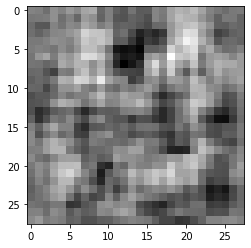

In [828]:
# synthesis Network
# 7x7
x = layers.Dense(7*7*LATENT_SIZE, activation="relu")(tf.random.normal((1, LATENT_SIZE)))
x = layers.Reshape((7, 7, LATENT_SIZE))(x)
x = layers.Conv2D(32, (3, 3), padding="same", kernel_initializer=tf.keras.initializers.GlorotNormal())(x)

# 14x14
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, (3, 3), padding="same", kernel_initializer=tf.keras.initializers.GlorotNormal())(x)

# 28x28
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, (3, 3), padding="same", kernel_initializer=tf.keras.initializers.GlorotNormal())(x)

x = layers.Dense(1, activation="tanh")(x)
plt.imshow(x[0], cmap="gray")
plt.show()

In [829]:
def make_discriminator_model():
    model = tf.keras.models.Sequential()

    filter_size = 24

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [830]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [831]:
discriminator(np.reshape(x[0], (1, 28, 28, 1)), training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5032907]], dtype=float32)>

## Define Losses

In [832]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    realLoss = cross_entropy(tf.ones_like(real_output), real_output)
    fakeLoss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return realLoss + fakeLoss

def generator_loss(fakeOutput):
    return cross_entropy(tf.ones_like(fakeOutput), fakeOutput)

## Define Optimizers

In [833]:
generatorOptimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminatorOptimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [834]:
NUM_SAMPLES_TO_GENERATE = 8
NUM_CHECKPOINT = 10


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = [tf.random.normal([NUM_SAMPLES_TO_GENERATE, LATENT_SIZE]) for i in range(3)] + [tf.random.normal([NUM_SAMPLES_TO_GENERATE, 7*2**i, 7*2**i, 1]) for i in range(3)]

In [835]:
checkpoint_dir = "./checkpoints2"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generatorOptimizer,
    discriminator_optimizer=discriminatorOptimizer,
    generator=generator,
    discriminator=discriminator,
)

## Define Training Steps

In [836]:
@tf.function
def train_step(images):
    latent = [tf.random.normal([NUM_SAMPLES_TO_GENERATE, LATENT_SIZE]) for i in range(3)] + [tf.random.normal([NUM_SAMPLES_TO_GENERATE, 7*2**i, 7*2**i, 1]) for i in range(3)]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(latent, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        genLoss = generator_loss(fake_output)
        discLoss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(genLoss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(discLoss, discriminator.trainable_variables)

    generatorOptimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminatorOptimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return genLoss, discLoss


In [837]:
def generate_and_save_images(model, epoch, test_input, history):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 4), constrained_layout=True)

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i + 1)
        plt.imshow((predictions[i].numpy()), cmap="gray")
        plt.axis("off")

    plt.savefig("./img2/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.legend(["Generator Loss", "Discriminator Loss"])
    plt.show()

In [838]:
def train(dataset, epochs):
    history = {
        'gen_loss': [],
        'disc_loss': []
    }

    generate_and_save_images(generator, 0, seed, history)

    for epoch in range(epochs):
        start = time.time()

        gen_loss = []
        disc_loss = []
        for image_batch in tqdm(dataset):
            h = train_step(image_batch)
            gen_loss.append(h[0])
            disc_loss.append(h[1])
        history['gen_loss'].append(tf.math.reduce_mean(gen_loss))
        history['disc_loss'].append(tf.math.reduce_mean(disc_loss))
        print(f"EPOCH: {epoch}\ngen_loss: {history['gen_loss'][-1]}\ndisc_loss: {history['disc_loss'][-1]}")
        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed, history)

        # Save the model every 15 epochs
        if (epoch + 1) % NUM_CHECKPOINT == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed, history)
    return history


## Train Model

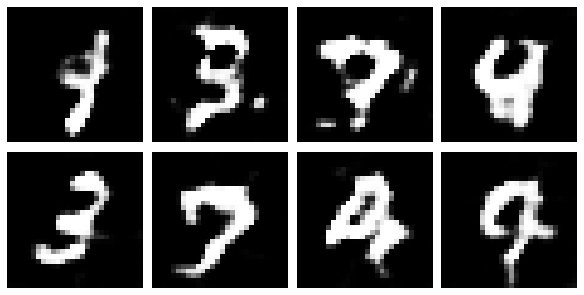

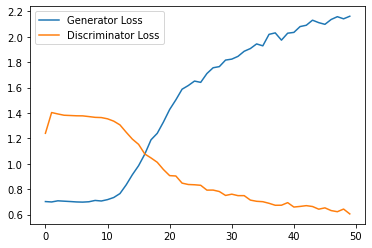

Finished


In [839]:
print("Starting")
history = train(train_ds, EPOCHS)
print("Finished")


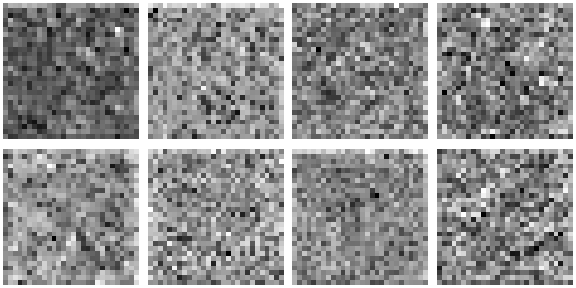

In [846]:
anim_file = "stylegan_MNIST.gif"

filenames = glob.glob("./img2/image_at_epoch_*.png")
images = [imageio.imread(filename) for filename in sorted(filenames)]
imageio.mimsave(anim_file, images, fps=8)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Evaluate model